In [0]:
%pip install hdbscan

Python interpreter will be restarted.
Collecting hdbscan
 Downloading hdbscan-0.8.28.tar.gz (5.2 MB)
 Installing build dependencies: started
 Installing build dependencies: finished with status 'done'
 Getting requirements to build wheel: started
 Getting requirements to build wheel: finished with status 'done'
 Preparing wheel metadata: started
 Preparing wheel metadata: finished with status 'done'
Requirement already satisfied: joblib>=1.0 in /databricks/python3/lib/python3.8/site-packages (from hdbscan) (1.0.1)
Requirement already satisfied: cython>=0.27 in /databricks/python3/lib/python3.8/site-packages (from hdbscan) (0.29.23)
Collecting numpy>=1.20
 Downloading numpy-1.22.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
Requirement already satisfied: scipy>=1.0 in /databricks/python3/lib/python3.8/site-packages (from hdbscan) (1.6.2)
Requirement already satisfied: scikit-learn>=0.20 in /databricks/python3/lib/python3.8/site-packages (from hdbscan) (0.24.1)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.20->hdbscan) (2.1.0)
Building wheels for collected packages: hdbscan
 Building wheel for hdbscan (PEP 517): started
 Building wheel for hdbscan (PEP 517): finished with status 'done'
 Created wheel for hdbscan: filename=hdbscan-0.8.28-cp38-cp38-linux_x86_64.whl size=3752147 sha256=7892b6d5d9597ca2c056104440fa4b755611c2f60d9c5ff9b2e1adadd413364c
 Stored in directory: /root/.cache/pip/wheels/dc/71/35/27e492e5848c7d1b38a6ea86e10261fd7ebaabf7e72c0b47c4
Successfully built hdbscan
Installing collected packages: numpy, hdbscan
 Attempting uninstall: numpy
 Found existing installation: numpy 1.19.2
 Not uninstalling numpy at /databricks/python3/lib/python3.8/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-43f07688-d8d8-4f36-a2e9-89dfb1c04283
 Can't uninstall 'numpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.2 requires pyspark>=2.1.0, which is not installed.
tensorflow-cpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.22.3 which is incompatible.
numba 0.54.0 requires numpy<1.21,>=1.17, but you have numpy 1.22.3 which is incompatible.
Successfully installed hdbscan-0.8.28 numpy-1.22.3
WARNING: You are using pip version 21.0.1; however, version 22.0.4 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-43f07688-d8d8-4f36-a2e9-89dfb1c04283/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
### Import libraries
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *
import pyspark.sql.functions as F
import pandas as pd
from datetime import date
from datetime import datetime
import numpy as np
import math
import itertools
from random import seed, choice
from random import randrange
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 

from matplotlib import pyplot as plt
import seaborn as sns

from databricks.feature_store import *

from pyspark.sql.types import *
from pyspark.sql.functions import when, lit, substring, col, coalesce, lead, datediff, expr, posexplode, year, concat, lpad, month, last_day, add_months, trunc, date_add, greatest
from pyspark.sql.window import Window

import hdbscan

In [0]:
# reading data from file
rubix5_eda = pd.read_csv('/dbfs/FileStore/onyshi1_rubix5_eda2.csv')

#target construction
#Target - CLAIM_COUNT_PAID / EARNED_EXPOSURES
rubix5_eda['TARGET'] = rubix5_eda['CLAIM_COUNT_PAID']/rubix5_eda['EARNED_EXPOSURES']
#Target_binary - 1 if CLAIM_COUNT_PAID > 0 else 0
rubix5_eda['TARGET_BINARY'] = rubix5_eda['CLAIM_COUNT_PAID'].apply(lambda x: 1 if x>0 else 0)


# apply filters - prepared by Julie, Thank you, Julie!
"""
    The Rubix 5 dataset is already limited to:
-Policies effective 1-1-2015 and later
-CSL only
-Power units only (no trailers)
-For Hire Trucking only (no public auto, business auto or garage)

Onyshchenko, Igor Additional filters needed will be SCHEDULED_FLEET = "YES" and COMPANY <> "FREEDOM SPECIALTY"
I think this covers it.  Let me know if anyone thinks I missed anything.
"""

rubix5_eda = rubix5_eda[rubix5_eda['SCHEDULED_FLEET']=="YES"]
rubix5_eda = rubix5_eda[rubix5_eda['COMPANY'] != 'FREEDOM SPECIALTY']

# there still was 'Brokerage Trans' and 'Business Auto' for I'm filtering it
rubix5_eda = rubix5_eda[rubix5_eda['VEHICLE_SEGMENT'].isin(['Large Fleet','Mid Fleet','Non Fleet'])]
rubix5_eda = rubix5_eda[rubix5_eda['POLICY_SEGMENT'].isin(['Large Fleet','Mid Fleet','Non Fleet'])]

#filtering earned exposures ==0 572 cases and <0 in 13 cases
rubix5_eda = rubix5_eda[rubix5_eda['EARNED_EXPOSURES'] > 0]

#filtering POLICYSTATE != 'HI' and 'MA'
rubix5_eda = rubix5_eda[rubix5_eda['POLICYSTATE'].isin(['HI', 'MA']) == False]

# filtering CLASS_CODE != 748900 - Non-Trucking 
rubix5_eda = rubix5_eda[rubix5_eda['CLASS_CD']!=748900]


# adding a column from Julie
rubix5_eda['REGION'] = rubix5_eda['POLICYSTATE'].copy()
rubix5_eda.loc[rubix5_eda['POLICYSTATE'] == 'CA', 'REGION'] = 'CALIFORNIA' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'] == 'FL', 'REGION'] = 'FLORIDA' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'] == 'TX', 'REGION'] = 'TEXAS' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["CT","DE","MA","MD","ME","NH","NJ","NY","PA","RI","VA","VT","WV"]), 'REGION'] = 'EAST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["IA","IL","IN","KS","KY","MI","MN","MO","ND","NE","OH","OK","SD","WI"]), 'REGION'] = 'MIDWEST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["AL","AR","GA","LA","MS","NC","SC","TN"]), 'REGION'] = 'SOUTHEAST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["AZ","CO","ID","MT","NM","NV","OR","UT","WA","WY"]), 'REGION'] = 'WEST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["AK","HI"]), 'REGION'] = 'OTHER' 

#resetting indexes
rubix5_eda.reset_index(drop=True, inplace = True)
# del rubix5_eda['Unnamed: 0']
rubix5_eda.head()



Out[2]:

,Unnamed: 0,DOT_NUMBER,POLICYID,POLICY_EFF_DT,VEHICLE_NO,POLICY_EXP_DT,POLICYSTATUS,POLICYISSUETYPE,COMPANY,POLICYSTATE,STATE_ADMITTED,NEW_VENTURE,PKGCOMBO,YRSINBUSCT,YRSOFINSCT,POLICY_SEGMENT,OPERATION_EXPOSURE_POLICY,ZONE_GRPCD_POLICY,SCHEDULED_FLEET,VEHICLE_SEGMENT,VEHICLE_TERRITORY,VEHICLE_STATE,MODEL_YEAR,EQUIPMENT_AGE,VIN,RADIUS_GROUP,CLASS_CD,ZONE_GRPCD_VEHICLE,VEHICLE_ZIPCD,CLASS_PRIMARY,CLASS_SECONDARY,VEHICLE_TYPE,TRANSFORM_TERRITORY,TERRITORY_GRP,OPERATION_EXPOSURE_VEHICLE,EARNED_EXP_TRANS,EARNED_EXPOSURES,AVG_DRIVER_SURCHARGE,LIAB_SCHMOD,LIAB_EXPERIMOD,...,PREM_WRITTEN_EFF,PREM_EARNED_EFF,OLEP_TRANS,OLEP_EFF,COVERAGE_GROUP,INDEMNITY_PAID,INDEMNITY_INCURRED,EXPENSE_PAID,EXPENSE_INCURRED,LARGE_LOSSES_100K,LARGE_LOSSES_250K,LARGE_LOSSES_500K,LARGE_LOSSES_1M,LATE_REPORTED_CLAIMS,CLAIM_COUNT_PAID,CLAIM_COUNT_NOT_PAID,CRASH_SCORE,BASIC_ALERTS,DRIVER_INSPECTIONS,DRIVER_OUT_OF_SERVICE,DRIVER_OOS_RATIO,VEHICLE_INSPECTIONS,VEHICLE_OUT_OF_SERVICE,VEHICLE_OOS_RATIO,DRIVING_WITHOUT_CDL,DRIVING_WO_CDL_RATIO,MCS150_UNIT_COUNT,MILEAGE_POWER_UNIT_RATIO,DRIVER_POWER_UNIT_RATIO,HOT_ZONE_INsPECTIONS,HOT_ZONE_RATIO,PREVIOUS_INSURERS,LENGTH_WITH_PRIOR,CRASHES_SEASON_1,CRASHES_SEASON_2,CRASHES_SEASON_3,CRASHES_SEASON_4,TARGET,TARGET_BINARY,REGION
0,10,831876,CAI0038074,2015-02-24,4,2016-02-24,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,TX,A,3RD YR NEW VENTURE,AUTO LIABILITY & AUTO PD ONLY,19.0,3.0,Non Fleet,OTHER,NaN,YES,Non Fleet,21,TX,2007.0,6-15,1M2AG11C97M051901,LOCAL,404520.0,NaN,77701.0,Extra Heavy Local Non-fleet,Waste Disposal - Building Wrecking Operators,Extra Heavy Non Zone Truckers,21,TX03,OTHER,0.005479,0.005479,1.000,1.0,1.0,...,18.0,18.0,27.07,27.07,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,6.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,8029.333333,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0,TEXAS
1,11,Unknown,CAI0043676,2015-07-11,1,2016-07-11,Cancelled,Renewal,SCOTTSDALE INDEMNITY COMPANY,CA,A,OTHER,AUTO LIABILITY ONLY,5.0,NaN,Non Fleet,OTHER,NaN,YES,Non Fleet,6,CA,1985.0,Over 16,2XKWD29X7FM914742,LOCAL,331840.0,NaN,91505.0,Heavy Commercial Local Fleet,Contractors - Excavating,Heavy Commercial Non Zone Truckers,106,CA01,OTHER,0.000000,0.454795,1.100,1.0,1.0,...,1141.0,1141.0,2967.83,2968.82,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,CALIFORNIA
2,12,Unknown,CAI0043717,2016-06-04,3,2017-06-04,Renewed,New,SCOTTSDALE INDEMNITY COMPANY,TX,A,OTHER,AUTO LIABILITY & AUTO PD ONLY,16.0,11.0,Non Fleet,DUMPING,NaN,YES,Non Fleet,6,TX,2005.0,6-15,1M2B209C15M030264,LOCAL,404790.0,NaN,77662.0,Extra Heavy Local Non-fleet,Dump and Transit Mix - All Other,Extra Heavy Non Zone Truckers,6,TX03,DUMPING,1.000000,1.000000,1.115,1.0,1.0,...,3457.0,3457.0,3532.47,3532.47,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,TEXAS
3,14,643526,CAI0044410,2018-04-29,16,2019-04-29,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,KY,A,OTHER,AUTO LIABILITY & AUTO PD ONLY,48.0,NaN,Mid Fleet,WASTE DISP,NaN,YES,Mid Fleet,106,KY,2010.0,6-15,2NKHHN6X1AM267776,LOCAL,334530.0,NaN,40923.0,Heavy Commercial Local Non-fleet,Waste Disposal - Garbage,Heavy Commercial Non Zone Truckers,106,KY02,WASTE DISP,1.000000,1.000000,1.039,1.0,1.0,...,2051.0,2051.0,1983.32,1983.32,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,7.0,0.0,6.0,0.0,0.0,5.0,1.0,0.2,0.0,0.0,17.0,29.411765,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,MIDWEST
4,15,422450,CAI0048094,2015-10-25,30,2016-10-25,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,IL,A,OTHER,AUTO LIABILITY ONLY,16.0,NaN,Mid Fleet,OTHER,NaN,YES,Mid Fleet,137,IL,1996.0,Over 16,4V4JBAPE3TN843398,LOCAL,344990.0,NaN,60804.0,Heavy truck-tractors Service Local Non-fleet,Not Otherwise Specified - All Other,Yard Non Zone Truckers,137,IL01,OTHER,0.947945,0.947945,1.004,1.0,1.0,...,1263.0,1263.0,1256.95,1256.99,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,4.0,NaN,1.5,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,

In [0]:
# keep only features that can be used for modelling
# the list of features prepared by Amanpreet and checked by Jason and Tyler, Thank you guys!

selected_columns = ['POLICYID',
'POLICY_EFF_DT',
'POLICYSTATUS',
'COMPANY',
'NEW_VENTURE',
'PKGCOMBO',
'YRSINBUSCT',
'YRSOFINSCT',
'POLICYSTATE',
'POLICY_SEGMENT',
'SCHEDULED_FLEET',
'VEHICLE_SEGMENT',
'VEHICLE_STATE',
'MODEL_YEAR',
'EQUIPMENT_AGE',
'VIN',
'RADIUS_GROUP',
'ZONE_GRPCD_VEHICLE',
'VEHICLE_ZIPCD',
'VEHICLE_TYPE',
'TRANSFORM_TERRITORY',
'TERRITORY_GRP',
'OPERATION_EXPOSURE_VEHICLE',
'AVG_DRIVER_SURCHARGE',
'VEHICLE_COUNT',
'LIMIT_CSL',
'DEDUCTIBLE_LIAB_TYPE',
'DEDUCTIBLE_LIAB_AMT',
'EARNED_EXPOSURES',
'CLAIM_COUNT_PAID',
# CAB features
# 'CRASH_SCORE',
# 'BASIC_ALERTS',
# 'DRIVER_INSPECTIONS',
# 'DRIVER_OUT_OF_SERVICE',
# 'DRIVER_OOS_RATIO',
# 'VEHICLE_INSPECTIONS',
# 'VEHICLE_OUT_OF_SERVICE',
# 'VEHICLE_OOS_RATIO',
# 'DRIVING_WITHOUT_CDL',
# 'DRIVING_WO_CDL_RATIO',
# 'MCS150_UNIT_COUNT',
# 'MILEAGE_POWER_UNIT_RATIO',
# 'DRIVER_POWER_UNIT_RATIO',
# 'HOT_ZONE_INsPECTIONS',
# 'HOT_ZONE_RATIO',
# 'PREVIOUS_INSURERS',
# 'LENGTH_WITH_PRIOR',
# 'CRASHES_SEASON_1',
# 'CRASHES_SEASON_2',
# 'CRASHES_SEASON_3',
# 'CRASHES_SEASON_4',
'REGION'
]


df = rubix5_eda[selected_columns]

# initial feature engineering
df['POLICY_YEAR'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[:4]).astype('int')
df['POLICY_MONTH'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[5:7]).astype('int')

df['VIN_GRP1'] = df['VIN'].apply(lambda x: str(x)[:1])
df.loc[df['VIN_GRP1'].isin(['1','2','3','4','5'])==False, 'VIN_GRP1'] = 'OTHER'

df['VIN_GRP2'] = df['VIN'].apply(lambda x: str(x)[:2])
df.loc[df['VIN_GRP2'].isin(['3W', '2X', '3F', '5P', '2N', '2W', '3C', '5K', '2F', '1G', '3H',
                           '1N','1H','1M', '2H', '3A', '4V', '1F', '1X'])==False, 'VIN_GRP2'] = 'OTHER'

df['VIN_GRP3'] = df['VIN'].apply(lambda x: str(x)[:3])
df.loc[df['VIN_GRP3'].isin(['2HT','2XK','3HA','4V1','4V5','2FW','3FR','3WK', '3C7', '2NP', '2NK', '1GB', '1GC', '3C6', '4VG', '1GD', '5PV',
       '2WK', '2FZ', '2FU', '5KK', '5KJ', '1FT', '3AL', '1HS', '1FD', '1NK',
       '1M1', '1FV', '1M2', '1NP', '3HS', '1HT', '2HS', '3AK', '4V4', '1XK',
       '1XP', '1FU'])==False, 'VIN_GRP3'] = 'OTHER'

del df['VIN']
del df['POLICY_EFF_DT']

# MODEL AGE
df['MODEL_AGE'] = df['POLICY_YEAR'] - df['MODEL_YEAR'] + 1

# target definition
df['TARGET'] = df['CLAIM_COUNT_PAID'] / df['EARNED_EXPOSURES']
df['TARGET_BINARY'] = df['CLAIM_COUNT_PAID'].apply(lambda x: 1 if x>0 else 0)

df = df[df['POLICY_YEAR']<2022]


# features for clastering
features = ['POLICYID','YRSINBUSCT', 'VEHICLE_COUNT']

# df on policy level
#filters - CALIFORNIA, 2017
state = 'CALIFORNIA'
policy_year = 2017

tmp = df[(df['POLICY_YEAR']==policy_year) & (df['REGION']==state)].groupby('POLICYID').agg({'POLICYID': np.max,'REGION': np.max, 'POLICYSTATE': np.max, 'PKGCOMBO': np.max, 'YRSINBUSCT': np.max, 'VEHICLE_COUNT': np.max, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})

tmp.columns = ['POLICYID','REGION', 'POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT', 'CLAIM_COUNT_PAID', 'EARNED_EXPOSURES']

tmp = tmp.reset_index(drop=True)
tmp['VEHICLE_COUNT_GRP'] = pd.cut(tmp['VEHICLE_COUNT'], [1, 2, 4, 10, 25, 200], include_lowest = True, right = False)

tmp['YRSINBUSCT_GRP'] = pd.qcut(tmp['YRSINBUSCT'], 8)

tmp

<command-7710095>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['POLICY_YEAR'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[:4]).astype('int')
<command-7710095>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['POLICY_MONTH'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[5:7]).astype('int')
<command-7710095>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['VIN_GRP1'] = df['VIN'].apply(lambda x: str(x)[:1])
/databricks/python/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 self._setitem_single_column(loc, value, pi)
<command-7710095>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['VIN_GRP2'] = df['VIN'].apply(lambda x: str(x)[:2])
/databricks/python/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 self._setitem_single_column(loc, value, pi)
<command-7710095>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['VIN_GRP3'] = df['VIN'].apply(lambda x: str(x)[:3])
/databricks/python/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 self._setitem_single_column(loc, value, pi)
<command-7710095>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['MODEL_AGE'] = df['POLICY_YEAR'] - df['MODEL_YEAR'] + 1
<command-7710095>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['TARGET'] = df['CLAIM_COUNT_PAID'] / df['EARNED_EXPOSURES']
<command-7710095>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,POLICYID,REGION,POLICYSTATE,PKGCOMBO,YRSINBUSCT,VEHICLE_COUNT,CLAIM_COUNT_PAID,EARNED_EXPOSURES,VEHICLE_COUNT_GRP,YRSINBUSCT_GRP
0,CAI0048753,CALIFORNIA,CA,AUTO LIABILITY & AUTO PD ONLY,9.0,2.0,0,2.000000,"[2, 4)","(8.0, 11.0]"
1,CAI0054498,CALIFORNIA,CA,AUTO LIABILITY ONLY,9.0,5.0,0,3.490411,"[4, 10)","(8.0, 11.0]"
2,CAI0058968,CALIFORNIA,CA,AUTO LIABILITY ONLY,11.0,2.0,0,2.000000,"[2, 4)","(8.0, 11.0]"
3,CAI0058971,CALIFORNIA,CA,AUTO LIABILITY ONLY,7.0,3.0,0,1.000000,"[2, 4)","(6.0, 8.0]"
4,CAI0058972,CALIFORNIA,CA,AUTO LIABILITY & AUTO PD ONLY,7.0,5.0,0,3.000000,"[4, 10)","(6.0, 8.0]"
...,...,...,...,...,...,...,...,...,...,...
2997,OPS0068945,CALIFORNIA,CA,AUTO LIAB/PD & MOTOR TRK CARGO,9.0,1.0,0,1.000000,"[1, 2)","(8.0, 11.0]"
2998,OPS0068946,CALIFORNIA,CA,AUTO LIAB/PD & MOTOR TRK CARGO,5.0,1.0,0,1.000000,"[1, 2)","(4.0, 5.0]"
2999,OPS0068947,CALIFORNIA,CA,AUTO LIAB/PD & MOTOR TRK CARGO,5.0,1.0,0,0.717808,"[1, 2)","(4.0, 5.0]"
3000,OPS0068948,CALIFORNIA,CA,AUTO LIAB/PD & MOTOR TRK CARGO,6.0,3.0,1,3.000000,"[2, 4)","(5.0, 6.0]"


In [0]:
# drop missings
print(tmp[features].isnull().sum())

#Dropping NA values as they are very less
tmp = tmp.dropna()
print(tmp.shape)



POLICYID 0
YRSINBUSCT 1
VEHICLE_COUNT 0
dtype: int64
(3001, 10)

In [0]:
cluster_df = tmp[features]
cluster_df = cluster_df.reset_index(drop = True)
del cluster_df['POLICYID']
cluster_df

Out[5]:

,YRSINBUSCT,VEHICLE_COUNT
0,9.0,2.0
1,9.0,5.0
2,11.0,2.0
3,7.0,3.0
4,7.0,5.0
...,...,...
2996,9.0,1.0
2997,5.0,1.0
2998,5.0,1.0
2999,6.0,3.0


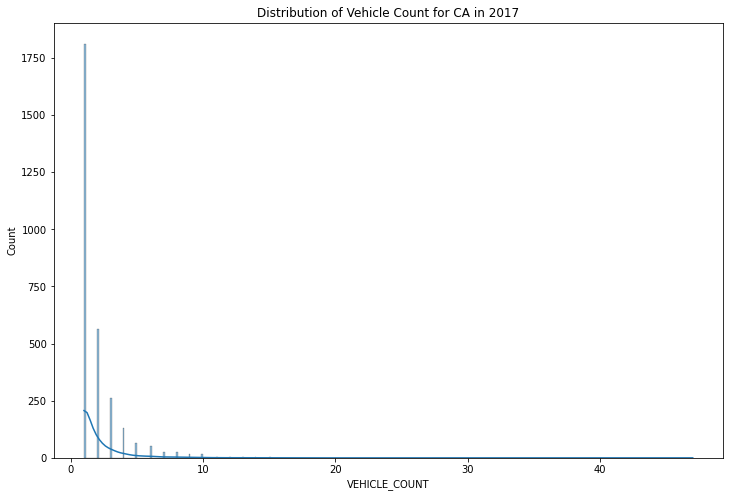

In [0]:
xlabel = cluster_df['VEHICLE_COUNT']
plt.figure(figsize=(12,8))
sns.histplot(x=xlabel,data=cluster_df,kde=True)
plt.title('Distribution of Vehicle Count for CA in 2017')
plt.show()

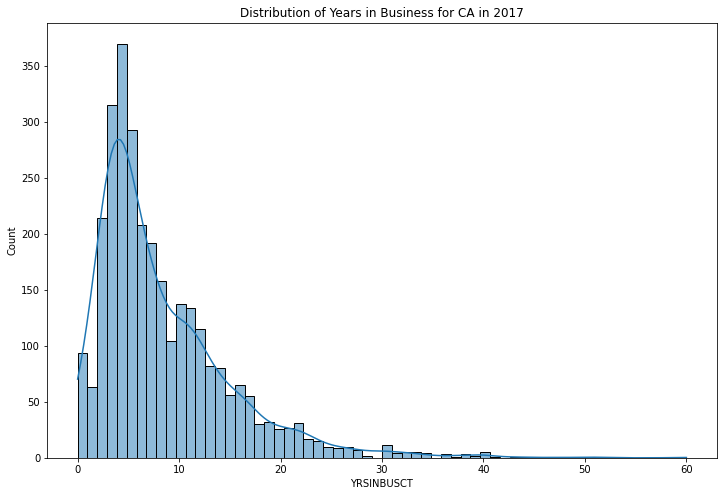

In [0]:
xlabel = cluster_df['YRSINBUSCT']
plt.figure(figsize=(12,8))
sns.histplot(x=xlabel,data=cluster_df,kde=True)
plt.title('Distribution of Years in Business for CA in 2017')
plt.show()

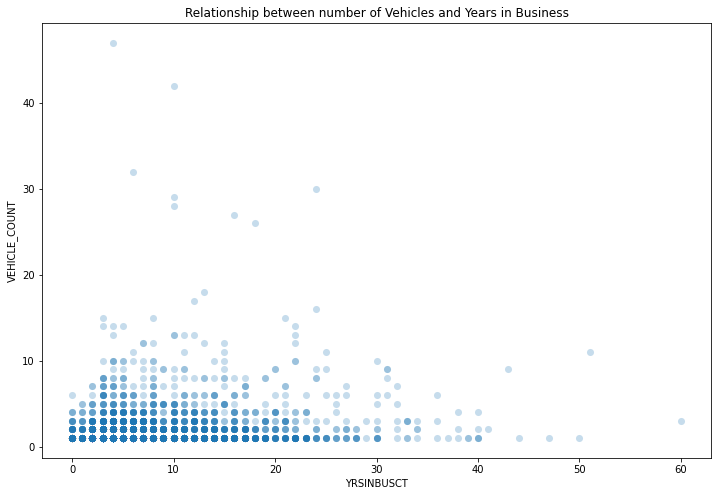

In [0]:
xlabel = cluster_df['YRSINBUSCT']
ylabel = cluster_df['VEHICLE_COUNT']
plt.figure(figsize=(12,8))
sns.scatterplot(x=xlabel,y=ylabel,data=cluster_df,s=50, linewidth=0, alpha=0.25)
plt.title('Relationship between number of Vehicles and Years in Business')
plt.show()


In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
warnings.simplefilter('ignore')

hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])

# parameters
param_dist={'min_samples': [1,3,5,10,30,50], 'min_cluster_size': [50, 100,200,300,400], 'cluster_selection_method': ['leaf'],
           'metric': ['euclidean', 'manhattan'], 'cluster_selection_epsilon': [0.2, 0.5, 1]}

# validity scorer
validity_scorer = make_scorer(hdbscan.validity.validity_index, greater_is_better = True)

SEED = 100
n_iter_search = 220
random_search = RandomizedSearchCV(hdb, param_distributions = param_dist, n_iter = n_iter_search, scoring = validity_scorer, random_state = SEED)
random_search.fit(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])

print(f"Best Parameter {random_search.best_params_}")
print(f"DBCV score: {random_search.best_estimator_.relative_validity_}")



Best Parameter {'min_samples': 1, 'min_cluster_size': 50, 'metric': 'euclidean', 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.2}
DBCV score: 0.48983672109296905

Estimated number of clusters: 6
Estimated number of noise points: 641
 CLUSTER_ID VEHICLE_COUNT YRSINBUSCT 
 size mean std mean std
CLUSTER_ID 
-1 641 3.171607 4.568425 12.842434 10.957666
 0 499 1.174349 0.452196 6.108216 1.008156
 1 216 3.023148 1.217860 5.986111 1.210340
 2 231 1.000000 0.000000 4.000000 0.000000
 3 618 1.673139 0.878313 2.870550 0.715247
 4 385 2.992208 2.364548 14.181818 3.106308
 5 411 1.223844 0.417327 10.051095 1.578767
Out[10]:

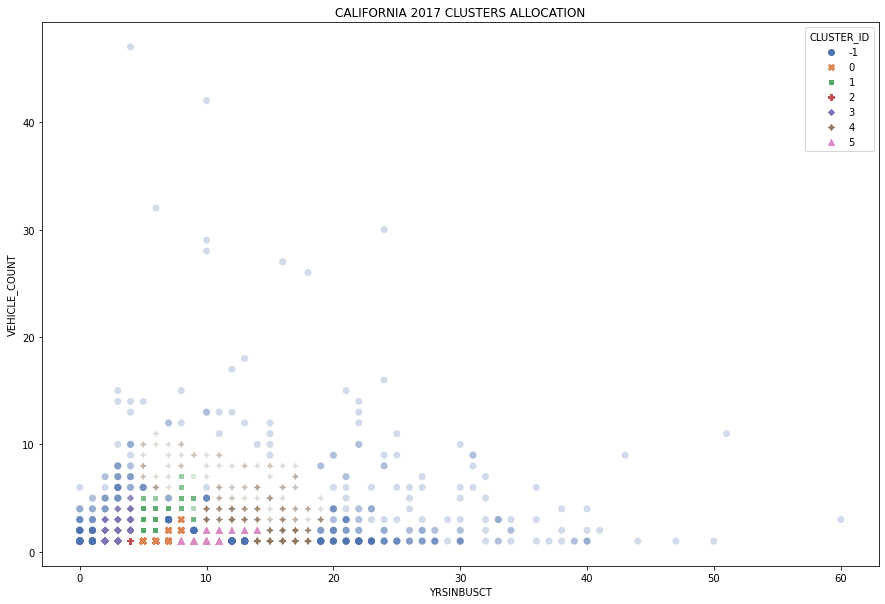

Text(0.5, 1.0, 'CALIFORNIA 2017 CLUSTERS ALLOCATION')

In [0]:
# Best Parameter {'min_samples': 1, 'min_cluster_size': 50, 'metric': 'euclidean', 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.2}
# DBCV score: 0.48983672109296905

# changed min_sample from 50 to 30 to decrease the number of noise (unclustered)
cluster = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=200, cluster_selection_epsilon = 0.2, metric='euclidean', cluster_selection_method = 'leaf')

cluster.fit_predict(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])

labels = cluster.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

cluster_df['CLUSTER_ID'] = labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

t = cluster_df.groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': [np.mean, np.std], 'YRSINBUSCT': [np.mean, np.std]})
print(t)

plt.figure(figsize = (15,10))
sns.scatterplot(x=cluster_df['YRSINBUSCT'], y=cluster_df['VEHICLE_COUNT'],data=cluster_df, s=50, linewidth=0, alpha=0.25, c=cluster_df['CLUSTER_ID'], style = 'CLUSTER_ID', hue='CLUSTER_ID', palette = 'deep')
plt.title('CALIFORNIA 2017 CLUSTERS ALLOCATION')

(786, 10)
Estimated number of clusters: 6
Estimated number of noise points: 158
 CLUSTER_ID VEHICLE_COUNT YRSINBUSCT 
 size mean std mean std
CLUSTER_ID 
-1 158 5.132911 4.679682 10.101266 9.776607
 0 126 1.309524 0.572214 6.198413 1.043225
 1 99 3.323232 1.202279 6.272727 1.376317
 2 58 1.000000 0.000000 4.000000 0.000000
 3 152 2.032895 1.069863 3.138158 0.700514
 4 96 3.833333 2.681974 12.479167 3.912138
 5 97 1.340206 0.476240 10.000000 1.581139
Out[11]:

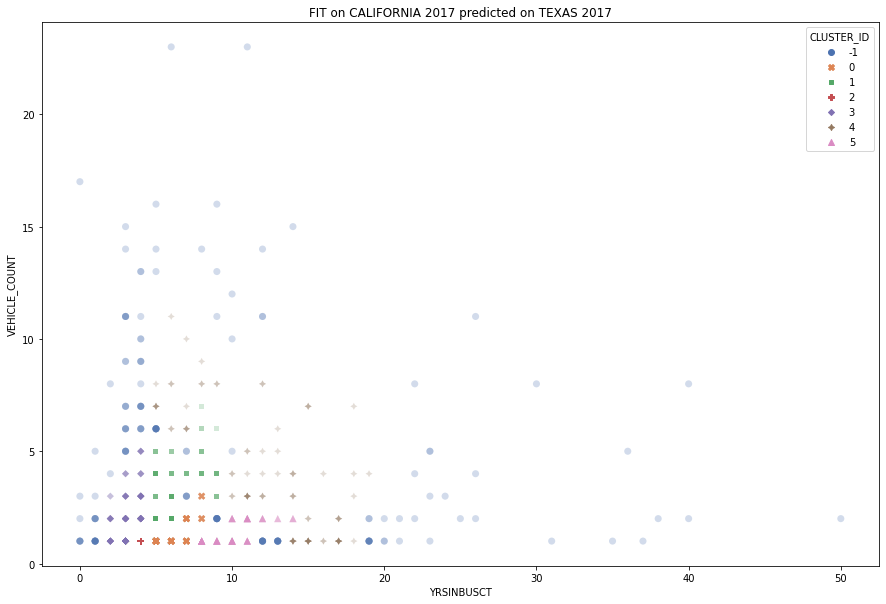

Text(0.5, 1.0, 'FIT on CALIFORNIA 2017 predicted on TEXAS 2017')

In [0]:

# changed min_sample from 50 to 30 to decrease the number of noise (unclustered)
cluster = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=200, cluster_selection_epsilon = 0.2, metric='euclidean', cluster_selection_method = 'leaf', prediction_data=True)
cluster.fit(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])

# prediction dataset for Texas 2017
state = 'TEXAS'
policy_year = 2017

tmp = df[(df['POLICY_YEAR']==policy_year) & (df['REGION']==state)].groupby('POLICYID').agg({'POLICYID': np.max,'REGION': np.max, 'POLICYSTATE': np.max, 'PKGCOMBO': np.max, 'YRSINBUSCT': np.max, 'VEHICLE_COUNT': np.max, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})
tmp.columns = ['POLICYID','REGION', 'POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT', 'CLAIM_COUNT_PAID', 'EARNED_EXPOSURES']
tmp = tmp.reset_index(drop=True)
tmp['VEHICLE_COUNT_GRP'] = pd.cut(tmp['VEHICLE_COUNT'], [1, 2, 4, 10, 25, 200], include_lowest = True, right = False)
tmp['YRSINBUSCT_GRP'] = pd.qcut(tmp['YRSINBUSCT'], 8)

tmp = tmp.dropna()
print(tmp.shape)
test_points = tmp[features]
test_points = test_points.reset_index(drop = True)
del test_points['POLICYID']


test_labels, strengths = hdbscan.approximate_predict(cluster, test_points)
test_labels


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(test_labels)) - (1 if -1 in test_labels else 0)
n_noise_ = list(test_labels).count(-1)

test_points['CLUSTER_ID'] = test_labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

t = test_points.groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': [np.mean, np.std], 'YRSINBUSCT': [np.mean, np.std]})
print(t)

plt.figure(figsize = (15,10))
sns.scatterplot(x=test_points['YRSINBUSCT'], y=test_points['VEHICLE_COUNT'],data=test_points, s=50, linewidth=0, alpha=0.25, c=cluster_df['CLUSTER_ID'], style = 'CLUSTER_ID', hue='CLUSTER_ID', palette = 'deep')
plt.title('FIT on CALIFORNIA 2017 predicted on TEXAS 2017')

(59409, 8)
Estimated number of clusters: 6
Estimated number of noise points: 16785
 CLUSTER_ID VEHICLE_COUNT YRSINBUSCT 
 size mean std mean std
CLUSTER_ID 
-1 16785 5.647781 7.825544 14.011439 12.607327
 0 8290 1.229192 0.505076 6.129916 1.026085
 1 5625 3.271644 1.261852 6.098844 1.336319
 2 3470 1.000000 0.000000 4.000000 0.000000
 3 10347 1.934764 1.042911 3.000387 0.717757
 4 8432 3.930977 2.723093 13.117291 3.741388
 5 6460 1.275077 0.446588 9.993344 1.500617

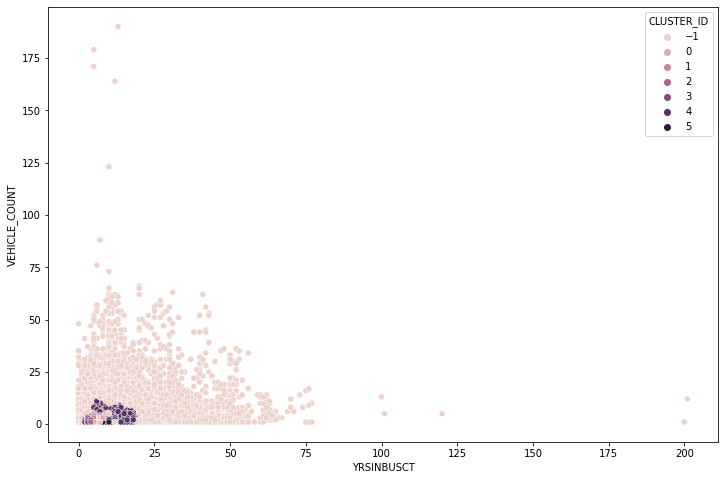

In [0]:
#dropping NAN values from clustering parameters
df.dropna(subset=['VEHICLE_COUNT','YRSINBUSCT'], inplace = True)
df[['VEHICLE_COUNT','YRSINBUSCT']]

# fitting stage with CALI 2017 data
cluster = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=200, cluster_selection_epsilon = 0.2, metric='euclidean', cluster_selection_method = 'leaf', prediction_data=True)
cluster.fit(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])


# prediction dataset for all policies

tmp = df.groupby('POLICYID').agg({'POLICYID': np.max,'REGION': np.max, 'POLICYSTATE': np.max, 'PKGCOMBO': np.max, 'YRSINBUSCT': np.max, 'VEHICLE_COUNT': np.max, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})
tmp.columns = ['POLICYID','REGION', 'POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT', 'CLAIM_COUNT_PAID', 'EARNED_EXPOSURES']
tmp = tmp.reset_index(drop=True)

tmp = tmp.dropna()
print(tmp.shape)
test_points = tmp[features]
test_points = test_points.reset_index(drop = True)
policyid = test_points['POLICYID']
del test_points['POLICYID']


# predicting and plotting all data
test_labels, strengths = hdbscan.approximate_predict(cluster, test_points)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(test_labels)) - (1 if -1 in test_labels else 0)
n_noise_ = list(test_labels).count(-1)

test_points['CLUSTER_ID'] = test_labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

t = test_points.groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': [np.mean, np.std], 'YRSINBUSCT': [np.mean, np.std]})
print(t)

plt.figure(figsize=(12,8))
sns.scatterplot(x=test_points['YRSINBUSCT'], y=test_points['VEHICLE_COUNT'],data=test_points,hue=test_points['CLUSTER_ID'])
plt.show()

Out[13]:

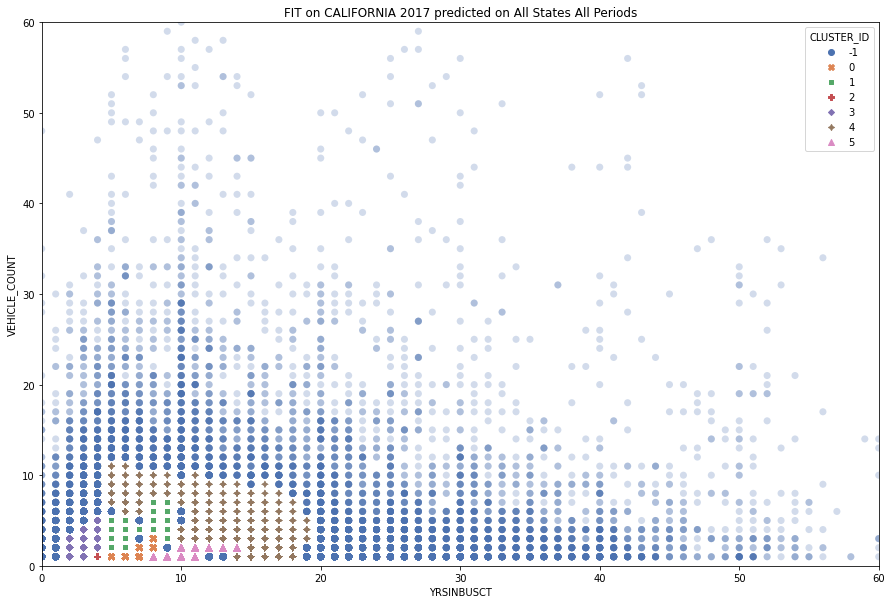

Text(0.5, 1.0, 'FIT on CALIFORNIA 2017 predicted on All States All Periods')

In [0]:
plt.figure(figsize = (15,10))
sns.scatterplot(x=test_points['YRSINBUSCT'], y=test_points['VEHICLE_COUNT'],data=test_points, s=50, linewidth=0, alpha=0.25, c=cluster_df['CLUSTER_ID'], style = 'CLUSTER_ID', hue='CLUSTER_ID', palette = 'deep')
plt.xlim([0,60])
plt.ylim([0,60])
plt.title('FIT on CALIFORNIA 2017 predicted on All States All Periods')

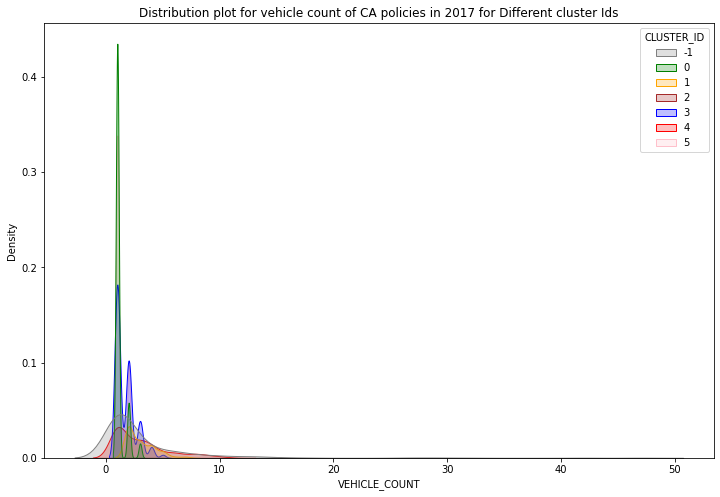

In [0]:
plt.figure(figsize=(12,8))
sns.kdeplot(x=cluster_df['VEHICLE_COUNT'],hue=cluster_df['CLUSTER_ID'],data=cluster_df,palette=['grey','green','orange','brown','blue','red','pink'],fill=True)
plt.title('Distribution plot for vehicle count of CA policies in 2017 for Different cluster Ids')
plt.show()

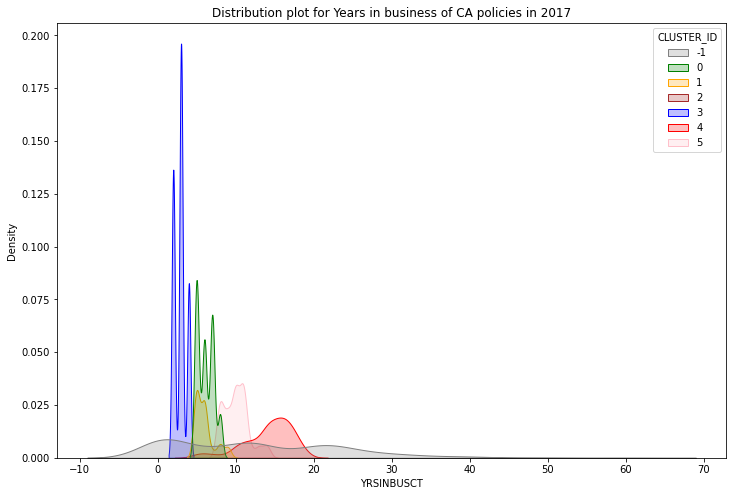

In [0]:
plt.figure(figsize=(12,8))
sns.kdeplot(x=cluster_df['YRSINBUSCT'],hue=cluster_df['CLUSTER_ID'],data=cluster_df,palette=['grey','green','orange','brown','blue','red','pink'],fill=True)
plt.title('Distribution plot for Years in business of CA policies in 2017')
plt.show()

Out[14]:

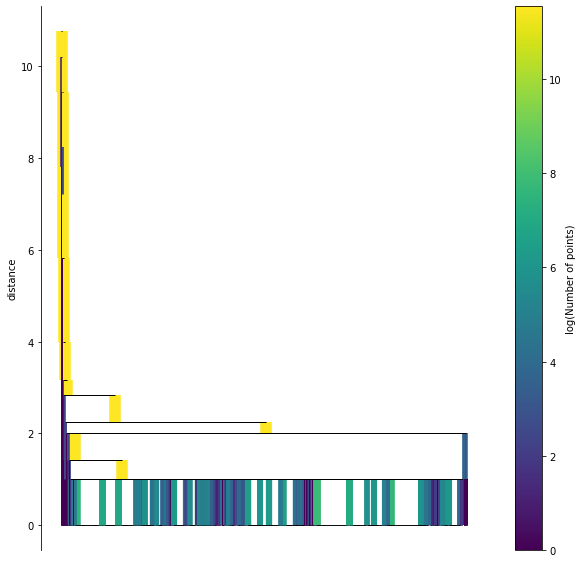

<AxesSubplot:ylabel='distance'>

In [0]:
plt.figure(figsize = (10,10))
cluster.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-43f07688-d8d8-4f36-a2e9-89dfb1c04283/lib/python3.8/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
 warn('Infinite lambda values encountered in chosen clusters.'
Out[15]:

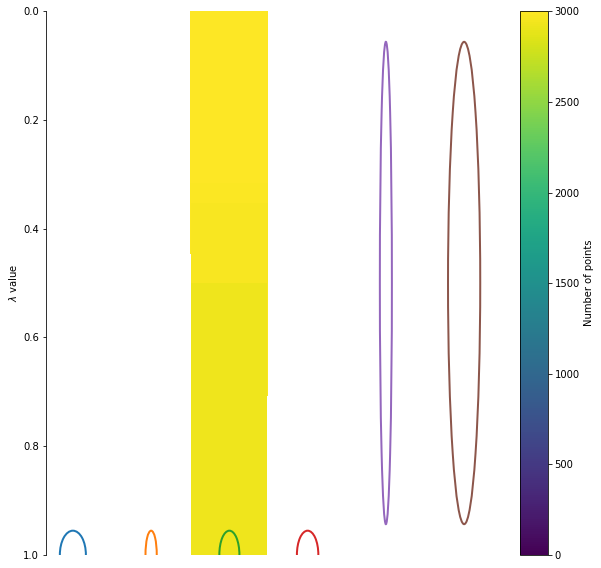

<AxesSubplot:ylabel='$\\lambda$ value'>

In [0]:
plt.figure(figsize = (10,10))
cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Out[16]:

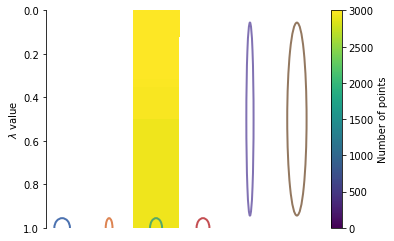

<AxesSubplot:ylabel='$\\lambda$ value'>

In [0]:
cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep', 8))

In [0]:
cluster_df = tmp[features]
cluster_df = cluster_df.reset_index(drop = True)
del cluster_df['POLICYID']
cluster_df

Out[21]:

,YRSINBUSCT,VEHICLE_COUNT
0,9.0,2.0
1,9.0,5.0
2,11.0,2.0
3,7.0,3.0
4,7.0,5.0
...,...,...
2996,9.0,1.0
2997,5.0,1.0
2998,5.0,1.0
2999,6.0,3.0


In [0]:
test_points['POLICYID'] = policyid
test_points['CLUSTER_DESCRIPTION'] = 'unclustered'
test_points.loc[test_points['CLUSTER_ID']==0, 'CLUSTER_DESCRIPTION'] = '1.2 Vehicles - 6 Years'
test_points.loc[test_points['CLUSTER_ID']==1, 'CLUSTER_DESCRIPTION'] = '3 Vehicles - 6 Years'
test_points.loc[test_points['CLUSTER_ID']==2, 'CLUSTER_DESCRIPTION'] = '1 Vehicle - 4 Years'
test_points.loc[test_points['CLUSTER_ID']==3, 'CLUSTER_DESCRIPTION'] = '2 Vehicles - 3 Years'
test_points.loc[test_points['CLUSTER_ID']==4, 'CLUSTER_DESCRIPTION'] = '3 Vehicles - 14 Years'
test_points.loc[test_points['CLUSTER_ID']==5, 'CLUSTER_DESCRIPTION'] = '1.3 Vehicles - 10 Years'
test_points

Out[17]:

,YRSINBUSCT,VEHICLE_COUNT,CLUSTER_ID,POLICYID,CLUSTER_DESCRIPTION
0,8.0,1.0,5,CAI0035521,1.3 Vehicles - 10 Years
1,4.0,1.0,2,CAI0035877,1 Vehicle - 4 Years
2,5.0,1.0,0,CAI0035879,1.2 Vehicles - 6 Years
3,10.0,1.0,5,CAI0037101,1.3 Vehicles - 10 Years
4,32.0,4.0,-1,CAI0037151,unclustered
...,...,...,...,...,...
59404,10.0,12.0,-1,TFO0000074,unclustered
59405,7.0,15.0,-1,TFO0000075,unclustered
59406,23.0,17.0,-1,TFS0000002,unclustered
59407,5.0,15.0,-1,TFS0000008,unclustered


In [0]:
rubix5_eda = rubix5_eda.merge(test_points[['POLICYID','CLUSTER_ID','CLUSTER_DESCRIPTION']], on = ['POLICYID'], how='inner')

In [0]:
rubix5_eda

Out[38]:

,Unnamed: 0,DOT_NUMBER,POLICYID,POLICY_EFF_DT,VEHICLE_NO,POLICY_EXP_DT,POLICYSTATUS,POLICYISSUETYPE,COMPANY,POLICYSTATE,STATE_ADMITTED,NEW_VENTURE,PKGCOMBO,YRSINBUSCT,YRSOFINSCT,POLICY_SEGMENT,OPERATION_EXPOSURE_POLICY,ZONE_GRPCD_POLICY,SCHEDULED_FLEET,VEHICLE_SEGMENT,VEHICLE_TERRITORY,VEHICLE_STATE,MODEL_YEAR,EQUIPMENT_AGE,VIN,RADIUS_GROUP,CLASS_CD,ZONE_GRPCD_VEHICLE,VEHICLE_ZIPCD,CLASS_PRIMARY,CLASS_SECONDARY,VEHICLE_TYPE,TRANSFORM_TERRITORY,TERRITORY_GRP,OPERATION_EXPOSURE_VEHICLE,EARNED_EXP_TRANS,EARNED_EXPOSURES,AVG_DRIVER_SURCHARGE,LIAB_SCHMOD,LIAB_EXPERIMOD,...,OLEP_TRANS,OLEP_EFF,COVERAGE_GROUP,INDEMNITY_PAID,INDEMNITY_INCURRED,EXPENSE_PAID,EXPENSE_INCURRED,LARGE_LOSSES_100K,LARGE_LOSSES_250K,LARGE_LOSSES_500K,LARGE_LOSSES_1M,LATE_REPORTED_CLAIMS,CLAIM_COUNT_PAID,CLAIM_COUNT_NOT_PAID,CRASH_SCORE,BASIC_ALERTS,DRIVER_INSPECTIONS,DRIVER_OUT_OF_SERVICE,DRIVER_OOS_RATIO,VEHICLE_INSPECTIONS,VEHICLE_OUT_OF_SERVICE,VEHICLE_OOS_RATIO,DRIVING_WITHOUT_CDL,DRIVING_WO_CDL_RATIO,MCS150_UNIT_COUNT,MILEAGE_POWER_UNIT_RATIO,DRIVER_POWER_UNIT_RATIO,HOT_ZONE_INsPECTIONS,HOT_ZONE_RATIO,PREVIOUS_INSURERS,LENGTH_WITH_PRIOR,CRASHES_SEASON_1,CRASHES_SEASON_2,CRASHES_SEASON_3,CRASHES_SEASON_4,TARGET,TARGET_BINARY,REGION,CLUSTER_ID,CLUSTER_DESCRIPTION
0,10,831876,CAI0038074,2015-02-24,4,2016-02-24,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,TX,A,3RD YR NEW VENTURE,AUTO LIABILITY & AUTO PD ONLY,19.0,3.0,Non Fleet,OTHER,NaN,YES,Non Fleet,21,TX,2007.0,6-15,1M2AG11C97M051901,LOCAL,404520.0,NaN,77701.0,Extra Heavy Local Non-fleet,Waste Disposal - Building Wrecking Operators,Extra Heavy Non Zone Truckers,21,TX03,OTHER,0.005479,0.005479,1.00,1.0,1.0,...,27.070000,27.07,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,6.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,8029.333333,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0,TEXAS,-1,unclustered
1,21590,831876,CAI0038074,2015-02-24,9,2016-02-24,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,TX,A,3RD YR NEW VENTURE,AUTO LIABILITY & AUTO PD ONLY,19.0,3.0,Non Fleet,OTHER,NaN,YES,Non Fleet,21,TX,2013.0,0-5,1XKDD49XXDJ365920,LOCAL,504520.0,NaN,77701.0,Extra-heavy Truck-tractors Local Non-fleet,Waste Disposal - Building Wrecking Operators,Extra-heavy Truck-tractors Non Zone Truckers,21,TX03,OTHER,1.000000,1.000000,1.00,1.0,1.0,...,5785.720000,5786.72,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,6.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,8029.333333,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0,TEXAS,-1,unclustered
2,161833,831876,CAI0038074,2015-02-24,11,2016-02-24,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,TX,A,3RD YR NEW VENTURE,AUTO LIABILITY & AUTO PD ONLY,19.0,3.0,Non Fleet,OTHER,NaN,YES,Non Fleet,21,TX,2015.0,0-5,1NKDLP0X8FJ461799,LOCAL,504520.0,NaN,77701.0,Extra-heavy Truck-tractors Local Non-fleet,Waste Disposal - Building Wrecking Operators,Extra-heavy Truck-tractors Non Zone Truckers,21,TX03,OTHER,1.000000,1.000000,1.00,1.0,1.0,...,5785.720000,5786.72,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,6.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,8029.333333,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0,TEXAS,-1,unclustered
3,176074,831876,CAI0038074,2015-02-24,8,2016-02-24,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,TX,A,3RD YR NEW VENTURE,AUTO LIABILITY & AUTO PD ONLY,19.0,3.0,Non Fleet,OTHER,NaN,YES,Non Fleet,21,TX,2009.0,6-15,1NKDL00X39J255205,LOCAL,404520.0,NaN,77701.0,Extra Heavy Local Non-fleet,Waste Disposal - Building Wrecking Operators,Extra Heavy Non Zone Truckers,21,TX03,OTHER,1.000000,1.000000,1.00,1.0,1.0,...,5342.670000,5342.67,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,6.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,8029.333333,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0,TEXAS,-1,unclustered
4,11,Unknown,CAI0043676,2015-07-11,1,2016-07-11,Cancelled,Renewal,SCOTTSDALE INDEMNITY COMPANY,CA,A,OTHER,AUTO LIABILITY ONLY,5.0,NaN,Non Fleet,OTHER,NaN,YES,Non Fleet,6,CA,1985.0,Over 16,2XKWD29X7FM914742,LOCAL,331840.0,NaN,91505.0,Heavy Commercial Local Fleet,Contractors - Excavating,Heavy Commercial Non Zone Truckers,106,CA01,OTHER,0.000000,0.454795,1.10,1.0,1.0,...,

In [0]:
# Jason lines
df_spark = spark.createDataFrame(rubix5_eda)
df_spark.write.mode('overwrite').saveAsTable('es.rubix5_clusters') #ess_rubix.rubix5_clusters es.rubix5_clusters
print('saved')
df_spark = spark.createDataFrame(test_points)
df_spark.write.mode('overwrite').saveAsTable('es.rubix5_clusters_policy_level') #ess_rubix.rubix5_clusters_policy_level
print('saved 2')

saved
saved 2

In [0]:
# savind data to file
rubix5_eda.to_csv('/dbfs/FileStore/rubix5_clusters.csv')
print('saved')
rubix5_eda.to_csv('/dbfs/FileStore/rubix5_clusters_policy_level.csv')
print('saved 2')

saved
saved 2

In [0]:
q = rubix5_eda.groupby('POLICYID').agg({'POLICYID': np.max, 'VEHICLE_COUNT': np.max, 'YRSINBUSCT': np.max, 'POLICYSTATE': np.max, 'REGION':np.max, 
                                      'POLICY_EFF_DT': np.max, 'CLUSTER_ID': np.max, 'CLUSTER_DESCRIPTION': np.max})
q['POLICY_YEAR'] = q['POLICY_EFF_DT'].apply(lambda x: x[:4])
q['POLICY_MONTH'] = q['POLICY_EFF_DT'].apply(lambda x: x[5:7])
q

Out[19]:

,POLICYID,VEHICLE_COUNT,YRSINBUSCT,POLICYSTATE,REGION,POLICY_EFF_DT,CLUSTER_ID,CLUSTER_DESCRIPTION,POLICY_YEAR,POLICY_MONTH
POLICYID,,,,,,,,,,
CAI0035521,CAI0035521,1.0,8.0,CA,CALIFORNIA,2018-07-18,5,1.3 Vehicles - 10 Years,2018,07
CAI0035877,CAI0035877,1.0,4.0,IA,MIDWEST,2017-04-08,2,1 Vehicle - 4 Years,2017,04
CAI0035879,CAI0035879,1.0,5.0,IA,MIDWEST,2018-04-08,0,1.2 Vehicles - 6 Years,2018,04
CAI0037101,CAI0037101,1.0,10.0,MN,MIDWEST,2016-06-17,5,1.3 Vehicles - 10 Years,2016,06
CAI0037151,CAI0037151,4.0,32.0,ND,MIDWEST,2016-05-23,-1,unclustered,2016,05
...,...,...,...,...,...,...,...,...,...,...
TFO0000074,TFO0000074,12.0,10.0,NV,WEST,2021-08-25,-1,unclustered,2021,08
TFO0000075,TFO0000075,15.0,7.0,OR,WEST,2021-09-15,-1,unclustered,2021,09
TFS0000002,TFS0000002,17.0,23.0,IN,MIDWEST,2021-01-06,-1,unclustered,2021,01


In [0]:
z = q[(q['POLICY_YEAR']=='2017')&(q['POLICYSTATE']=='CA')&(q['POLICY_MONTH'].isin(['01','02','03']))].groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})

z['PERCENTAGE'] = z['CLUSTER_ID']/z['CLUSTER_ID'].sum()
z[['CLUSTER_ID','PERCENTAGE']]

Out[32]:

,CLUSTER_ID,PERCENTAGE
CLUSTER_ID,,
-1,181,0.201335
0,173,0.192436
1,52,0.057842
2,100,0.111235
3,186,0.206897
4,94,0.104561
5,113,0.125695


In [0]:
# STATE AND YEAR
z = q[(q['POLICY_YEAR']=='2021')&(q['POLICYSTATE']=='CA')].groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})
z['PERCENTAGE'] = z['CLUSTER_ID']/z['CLUSTER_ID'].sum()

z[['CLUSTER_ID','PERCENTAGE']]

Out[48]:

,CLUSTER_ID,PERCENTAGE
CLUSTER_ID,,
-1,264,0.206897
0,242,0.189655
1,117,0.091693
2,88,0.068966
3,214,0.167712
4,194,0.152038
5,157,0.123041


In [0]:
# POPULATION STABILITY INDEX
year = '2021'
state_base = 'CA'
state_test = 'TX'

base = q[(q['POLICY_YEAR']==year)&(q['POLICYSTATE']==state_base)].groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})
base['PERCENTAGE'] = base['CLUSTER_ID']/base['CLUSTER_ID'].sum()

test = q[(q['POLICY_YEAR']==year)&(q['POLICYSTATE']==state_test)].groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})
test['PERCENTAGE'] = test['CLUSTER_ID']/test['CLUSTER_ID'].sum()

PSI = np.sum( (base['PERCENTAGE'] - test['PERCENTAGE']) * np.log(base['PERCENTAGE']/test['PERCENTAGE']) )
PSI

In [0]:
  # YEAR by YEAR POPULATION
z = q[(q['POLICY_YEAR']=='2021')].groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': np.mean, 'YRSINBUSCT': np.mean})
z['PERCENTAGE'] = z['CLUSTER_ID']/z['CLUSTER_ID'].sum()

z[['CLUSTER_ID','PERCENTAGE']]

Out[75]:

,CLUSTER_ID,PERCENTAGE
CLUSTER_ID,,
-1,1215,0.218094
0,1053,0.189015
1,603,0.108239
2,373,0.066954
3,925,0.166038
4,757,0.135882
5,645,0.115778


In [0]:
# normalazing VEHICLE_COUNT and YRSINBUSCT
from sklearn.preprocessing import StandardScaler,MinMaxScaler
standard = StandardScaler()
minMax = MinMaxScaler()

cluster_df[['YRSINBUSCT_STD','VEHICLE_COUNT_STD']] = standard.fit_transform(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])
cluster_df[['YRSINBUSCT_MM','VEHICLE_COUNT_MM']] = minMax.fit_transform(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])

cluster_df

Out[41]:

,YRSINBUSCT,VEHICLE_COUNT,CLUSTER_ID,YRSINBUSCT_STD,VEHICLE_COUNT_STD,YRSINBUSCT_MM,VEHICLE_COUNT_MM
0,9.0,2.0,-1,0.106058,-0.025275,0.150000,0.021739
1,9.0,5.0,1,0.106058,1.172373,0.150000,0.086957
2,11.0,2.0,5,0.402545,-0.025275,0.183333,0.021739
3,7.0,3.0,-1,-0.190430,0.373941,0.116667,0.043478
4,7.0,5.0,-1,-0.190430,1.172373,0.116667,0.086957
...,...,...,...,...,...,...,...
2996,9.0,1.0,5,0.106058,-0.424491,0.150000,0.000000
2997,5.0,1.0,0,-0.486917,-0.424491,0.083333,0.000000
2998,5.0,1.0,0,-0.486917,-0.424491,0.083333,0.000000
2999,6.0,3.0,1,-0.338673,0.373941,0.100000,0.043478


In [0]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer

hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(cluster_df[['YRSINBUSCT_MM','VEHICLE_COUNT_MM']])

# parameters
param_dist={'min_samples': [1,3,5,10,30,50], 'min_cluster_size': [50,100,200,300,400], 'cluster_selection_method': ['leaf'],
           'metric': ['euclidean', 'manhattan'], 'cluster_selection_epsilon': [0.2, 0.5, 1]}

# validity scorer
validity_scorer = make_scorer(hdbscan.validity.validity_index, greater_is_better = True)

SEED = 100
n_iter_search = 200
random_search = RandomizedSearchCV(hdb, param_distributions = param_dist, n_iter = n_iter_search, scoring = validity_scorer, random_state = SEED)
random_search.fit(cluster_df[['YRSINBUSCT_MM','VEHICLE_COUNT_MM']])

print(f"Best Parameter {random_search.best_params_}")
print(f"DBCV score: {random_search.best_estimator_.relative_validity_}")



Best Parameter {'min_samples': 1, 'min_cluster_size': 50, 'metric': 'euclidean', 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.2}
DBCV score: 1.2501662484305802e-15

Estimated number of clusters: 2
Estimated number of noise points: 200
 CLUSTER_ID VEHICLE_COUNT YRSINBUSCT 
 size mean std mean std
CLUSTER_ID 
-1 200 8.300000 6.192068 16.510000 12.826633
 0 995 2.730653 0.975461 7.763819 5.306264
 1 1806 1.004983 0.070437 7.660576 5.828811

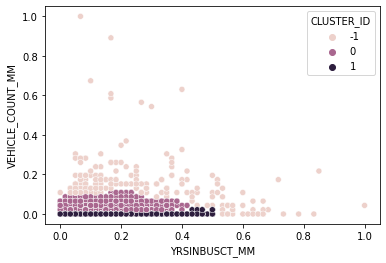

In [0]:
# Best Parameter {'min_samples': 1, 'min_cluster_size': 50, 'metric': 'euclidean', 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.2}
# DBCV score: 1.2501662484305802e-15

cluster = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=300, cluster_selection_epsilon = 0.2, cluster_selection_method = 'leaf', metric='euclidean')
cluster.fit_predict(cluster_df[['YRSINBUSCT_MM','VEHICLE_COUNT_MM']])

labels = cluster.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

cluster_df['CLUSTER_ID'] = labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

t = cluster_df.groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': [np.mean, np.std], 'YRSINBUSCT': [np.mean, np.std]})
print(t)

sns.scatterplot(x=cluster_df['YRSINBUSCT_MM'], y=cluster_df['VEHICLE_COUNT_MM'],data=cluster_df,hue=cluster_df['CLUSTER_ID'])
plt.show()


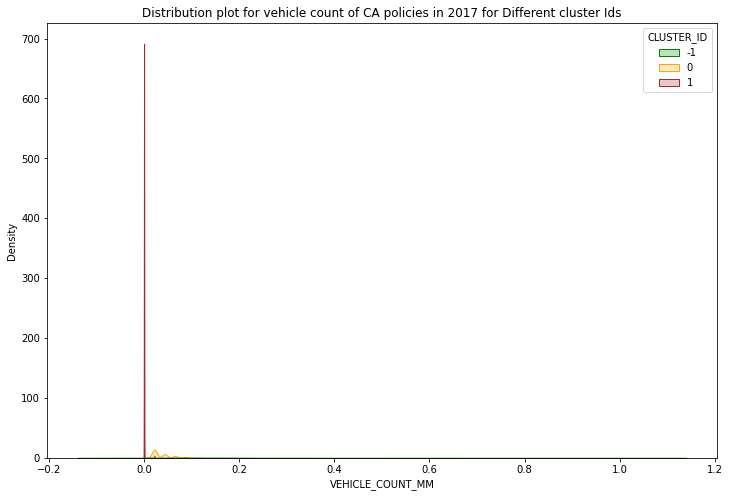

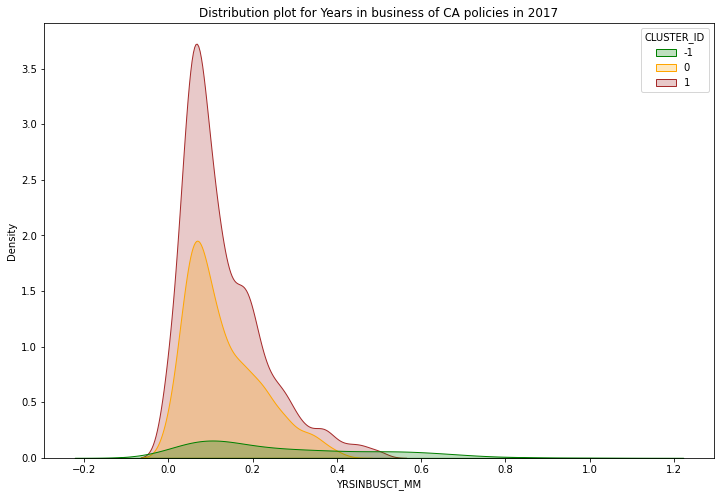

In [0]:
plt.figure(figsize=(12,8))
xlabel = cluster_df['VEHICLE_COUNT_MM']
sns.kdeplot(x=cluster_df['VEHICLE_COUNT_MM'],hue=cluster_df['CLUSTER_ID'],data=cluster_df,palette=['green','orange','brown'],fill=True)
#,'blue','red','grey'
plt.title('Distribution plot for vehicle count of CA policies in 2017 for Different cluster Ids')
plt.show()

plt.figure(figsize=(12,8))
sns.kdeplot(x=cluster_df['YRSINBUSCT_MM'],hue=cluster_df['CLUSTER_ID'],data=cluster_df,palette=['green','orange','brown'],fill=True)
plt.title('Distribution plot for Years in business of CA policies in 2017')
plt.show()

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(cluster_df[['YRSINBUSCT_STD','VEHICLE_COUNT_STD']])

# parameters
param_dist={'min_samples': [1,3,5,10,30,50], 'min_cluster_size': [50,100,200,300,400], 'cluster_selection_method': ['leaf'],
           'metric': ['euclidean', 'manhattan'], 'cluster_selection_epsilon': [0.2, 0.5, 1]}

# validity scorer
validity_scorer = make_scorer(hdbscan.validity.validity_index, greater_is_better = True)

SEED = 100
n_iter_search = 100
random_search = RandomizedSearchCV(hdb, param_distributions = param_dist, n_iter = n_iter_search, scoring = validity_scorer, random_state = SEED)
random_search.fit(cluster_df[['YRSINBUSCT_STD','VEHICLE_COUNT_STD']])

print(f"Best Parameter {random_search.best_params_}")
print(f"DBCV score: {random_search.best_estimator_.relative_validity_}")



Best Parameter {'min_samples': 30, 'min_cluster_size': 400, 'metric': 'euclidean', 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.5}
DBCV score: 0.19807545250422887

Estimated number of clusters: 2
Estimated number of noise points: 691
 CLUSTER_ID VEHICLE_COUNT YRSINBUSCT 
 size mean std mean std
CLUSTER_ID 
-1 691 4.848046 4.075207 11.84081 9.647895
 0 532 2.000000 0.000000 6.81391 4.592341
 1 1778 1.000000 0.000000 7.34252 5.286630

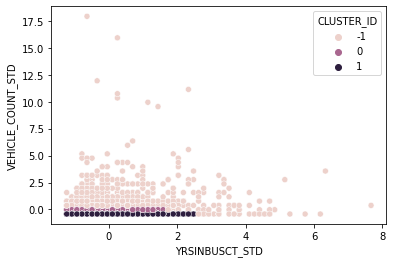

In [0]:
# Best Parameter {'min_samples': 30, 'min_cluster_size': 400, 'metric': 'euclidean', 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.5}
# DBCV score: 0.19807545250422887

cluster = hdbscan.HDBSCAN(min_samples=30,min_cluster_size=400, cluster_selection_epsilon = 0.5, cluster_selection_method = 'leaf', metric='euclidean')
cluster.fit_predict(cluster_df[['YRSINBUSCT_STD','VEHICLE_COUNT_STD']])

labels = cluster.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

cluster_df['CLUSTER_ID'] = labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

t = cluster_df.groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': [np.mean, np.std], 'YRSINBUSCT': [np.mean, np.std]})
print(t)

sns.scatterplot(x=cluster_df['YRSINBUSCT_STD'], y=cluster_df['VEHICLE_COUNT_STD'],data=cluster_df,hue=cluster_df['CLUSTER_ID'])
plt.show()


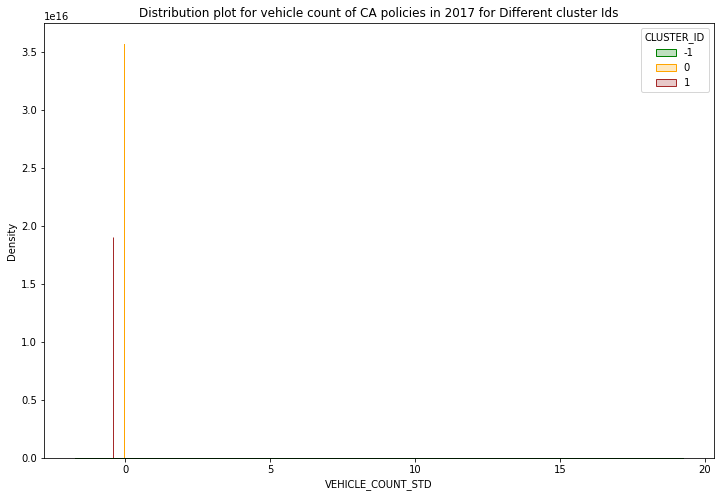

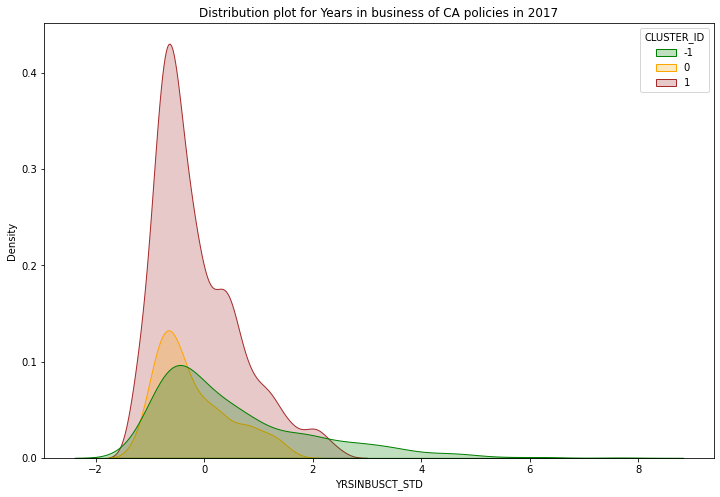

In [0]:
plt.figure(figsize=(12,8))
xlabel = cluster_df['VEHICLE_COUNT_STD']
sns.kdeplot(x=cluster_df['VEHICLE_COUNT_STD'],hue=cluster_df['CLUSTER_ID'],data=cluster_df,palette=['green','orange','brown'],fill=True)
#,'blue','red','grey'
plt.title('Distribution plot for vehicle count of CA policies in 2017 for Different cluster Ids')
plt.show()

plt.figure(figsize=(12,8))
sns.kdeplot(x=cluster_df['YRSINBUSCT_STD'],hue=cluster_df['CLUSTER_ID'],data=cluster_df,palette=['green','orange','brown'],fill=True)
plt.title('Distribution plot for Years in business of CA policies in 2017')
plt.show()